## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

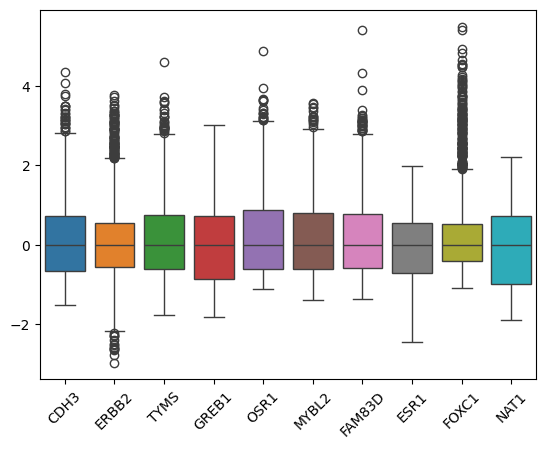

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

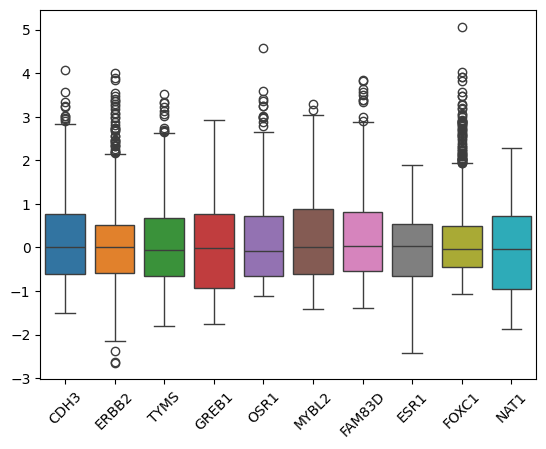

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("X_test_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)
y_test_encoder = encoder.transform(y_test)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)
y_test = pd.Series(y_test_encoder, index = y_test.index)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

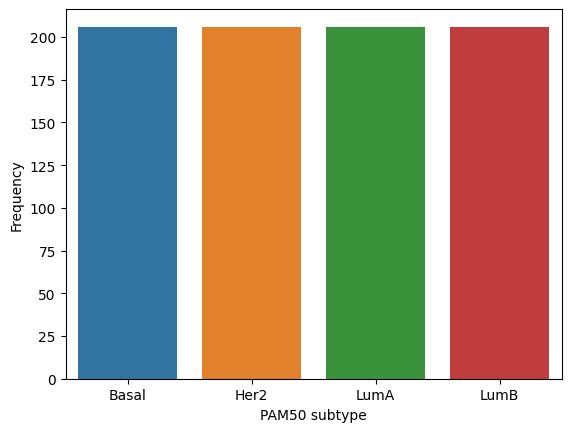

In [9]:
# Check count for each class in the training data.
class_counts = y_res.groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Compare model performance between original and undersampled data.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
clf = RandomForestClassifier(random_state = 42)
precision = make_scorer(precision_score, average = 'macro', zero_division = 0)
recall = make_scorer(recall_score, average = 'macro', zero_division = 0)

scoring = {"accuracy" : "accuracy",
           "precision" : precision,
           "recall" : recall,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

origianl_score = cross_validate(clf, X_train, y_train, cv = cv, scoring = scoring, return_train_score = True)
undersample_score = cross_validate(clf, X_res, y_res, cv = cv, scoring = scoring, return_train_score = True)

In [11]:
print("Mean train accuracy (original) =", np.mean(origianl_score["train_accuracy"]), "±", np.std(origianl_score["train_accuracy"]))
print("Mean validation accuracy (original) =", np.mean(origianl_score["test_accuracy"]), "±", np.std(origianl_score["test_accuracy"]), "\n")
print("Mean train precision (original) =", np.mean(origianl_score["train_precision"]), "±", np.std(origianl_score["train_precision"]))
print("Mean validation precision (original) =", np.mean(origianl_score["test_precision"]), "±", np.std(origianl_score["test_precision"]), "\n")
print("Mean train recall (original) =", np.mean(origianl_score["train_recall"]), "±", np.std(origianl_score["train_recall"]))
print("Mean validation recall (original) =", np.mean(origianl_score["test_recall"]), "±", np.std(origianl_score["test_recall"]), "\n")
print("Mean train F1-score (original) =", np.mean(origianl_score["train_f1-score"]), "±", np.std(origianl_score["train_f1-score"]))
print("Mean validation F1-score (original) =", np.mean(origianl_score["test_f1-score"]), "±", np.std(origianl_score["test_f1-score"]), "\n")
print("Mean train AUROC (original) =", np.mean(origianl_score["train_auc"]), "±", np.std(origianl_score["train_auc"]))
print("Mean validation AUROC (original) =", np.mean(origianl_score["test_auc"]), "±", np.std(origianl_score["test_auc"]), "\n")

Mean train accuracy (original) = 1.0 ± 0.0
Mean validation accuracy (original) = 0.882674803696384 ± 0.019725021161913277 

Mean train precision (original) = 1.0 ± 0.0
Mean validation precision (original) = 0.8843931250451429 ± 0.02418109593084784 

Mean train recall (original) = 1.0 ± 0.0
Mean validation recall (original) = 0.8584915960964082 ± 0.02469795225699913 

Mean train F1-score (original) = 1.0 ± 0.0
Mean validation F1-score (original) = 0.8693376773388087 ± 0.02303471240302441 

Mean train AUROC (original) = 1.0 ± 0.0
Mean validation AUROC (original) = 0.9773538425829444 ± 0.006704953722939573 



In [12]:
print("Mean train accuracy (undersampled) =", np.mean(undersample_score["train_accuracy"]), "±", np.std(undersample_score["train_accuracy"]))
print("Mean validation accuracy (undersampled) =", np.mean(undersample_score["test_accuracy"]), "±", np.std(undersample_score["test_accuracy"]), "\n")
print("Mean train precision (undersampled) =", np.mean(undersample_score["train_precision"]), "±", np.std(undersample_score["train_precision"]))
print("Mean validation precision (undersampled) =", np.mean(undersample_score["test_precision"]), "±", np.std(undersample_score["test_precision"]), "\n")
print("Mean train recall (undersampled) =", np.mean(undersample_score["train_recall"]), "±", np.std(undersample_score["train_recall"]))
print("Mean validation recall (undersampled) =", np.mean(undersample_score["test_recall"]), "±", np.std(undersample_score["test_recall"]), "\n")
print("Mean train F1-score (undersampled) =", np.mean(undersample_score["train_f1-score"]), "±", np.std(undersample_score["train_f1-score"]))
print("Mean validation F1-score (undersampled) =", np.mean(undersample_score["test_f1-score"]), "±", np.std(undersample_score["test_f1-score"]), "\n")
print("Mean train AUROC (undersampled) =", np.mean(undersample_score["train_auc"]), "±", np.std(undersample_score["train_auc"]))
print("Mean validation AUROC (undersampled) =", np.mean(undersample_score["test_auc"]), "±", np.std(undersample_score["test_auc"]), "\n")

Mean train accuracy (undersampled) = 1.0 ± 0.0
Mean validation accuracy (undersampled) = 0.8615265941816045 ± 0.03779589377227168 

Mean train precision (undersampled) = 1.0 ± 0.0
Mean validation precision (undersampled) = 0.8679310921665107 ± 0.03638906338025145 

Mean train recall (undersampled) = 1.0 ± 0.0
Mean validation recall (undersampled) = 0.861690476190476 ± 0.037871414650354 

Mean train F1-score (undersampled) = 1.0 ± 0.0
Mean validation F1-score (undersampled) = 0.8620501494605416 ± 0.03734089846446793 

Mean train AUROC (undersampled) = 1.0 ± 0.0
Mean validation AUROC (undersampled) = 0.9754041069120227 ± 0.009877027426383876 



### Hyperparameter tuning using GridSearchCV

In [13]:
hyperparameters = {'n_estimators' : list(range(5, 51, 5)),
                   'max_depth' : [2, 3, 5],
                   'min_samples_leaf' : [2, 3, 5],
                   'min_samples_split': [2, 3, 5],
                   'class_weight' : [None, 'balanced']}

optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = -1, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_train, y_train)

In [14]:
print('가장 좋은 n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('가장 좋은 max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('가장 좋은 min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('가장 좋은 min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('가장 좋은 class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print("가장 좋은 Score :", best_model.best_score_)

가장 좋은 n_estimators: 40
가장 좋은 max_depth: 5
가장 좋은 min_samples_leaf: 2
가장 좋은 min_samples_split: 5
가장 좋은 class_weight: None
가장 좋은 Score : 0.8624023823513702


In [15]:
# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_precision', 'std_train_precision', 'mean_test_precision', 'std_test_precision',
                  'mean_train_recall', 'std_train_recall', 'mean_test_recall', 'std_test_recall',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3,4,5,6,7,8,9,...,530,531,532,533,534,535,536,537,538,539
params,"{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...","{'class_weight': None, 'max_depth': 5, 'min_sa...",...,"{'class_weight': 'balanced', 'max_depth': 2, '...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa...","{'class_weight': None, 'max_depth': 2, 'min_sa..."
mean_train_accuracy,0.903026,0.904544,0.903186,0.903186,0.903891,0.903891,0.903891,0.902854,0.902854,0.902854,...,0.772093,0.764982,0.764982,0.764982,0.764982,0.764982,0.764982,0.764982,0.764982,0.764982
std_train_accuracy,0.003574,0.003172,0.003511,0.003511,0.003461,0.003461,0.003461,0.00356,0.00356,0.00356,...,0.014006,0.006988,0.006988,0.006988,0.006988,0.006988,0.006988,0.006988,0.006988,0.006988
mean_test_accuracy,0.862402,0.862145,0.861989,0.861989,0.861837,0.861837,0.861837,0.861835,0.861835,0.861835,...,0.761214,0.755131,0.755131,0.755131,0.755131,0.755131,0.755131,0.755131,0.755131,0.755131
std_test_accuracy,0.022338,0.022497,0.021765,0.021765,0.022423,0.022423,0.022423,0.022006,0.022006,0.022006,...,0.032682,0.026122,0.026122,0.026122,0.026122,0.026122,0.026122,0.026122,0.026122,0.026122
mean_train_precision,0.923662,0.92524,0.924291,0.924291,0.924225,0.924225,0.924225,0.923484,0.923484,0.923484,...,0.765044,0.767188,0.767188,0.767188,0.767188,0.767188,0.767188,0.767188,0.767188,0.767188
std_train_precision,0.003797,0.00337,0.003769,0.003769,0.003694,0.003694,0.003694,0.004018,0.004018,0.004018,...,0.012961,0.023238,0.023238,0.023238,0.023238,0.023238,0.023238,0.023238,0.023238,0.023238
mean_test_precision,0.877919,0.877288,0.877254,0.877254,0.877135,0.877135,0.877135,0.877732,0.877732,0.877732,...,0.754111,0.752875,0.752875,0.752875,0.752875,0.752875,0.752875,0.752875,0.752875,0.752875
std_test_precision,0.026147,0.025753,0.02683,0.02683,0.025764,0.025764,0.025764,0.025317,0.025317,0.025317,...,0.03606,0.048385,0.048385,0.048385,0.048385,0.048385,0.048385,0.048385,0.048385,0.048385
mean_train_recall,0.875304,0.876908,0.875199,0.875199,0.87593,0.87593,0.87593,0.874486,0.874486,0.874486,...,0.7822,0.678419,0.678419,0.678419,0.678419,0.678419,0.678419,0.678419,0.678419,0.678419


### Model evaluation using hyperparameter

In [16]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [17]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.94      0.84      0.89        92
        Her2       0.88      0.67      0.76        89
        LumA       0.87      0.93      0.90       450
        LumB       0.73      0.74      0.74       200

    accuracy                           0.85       831
   macro avg       0.86      0.80      0.82       831
weighted avg       0.85      0.85      0.84       831



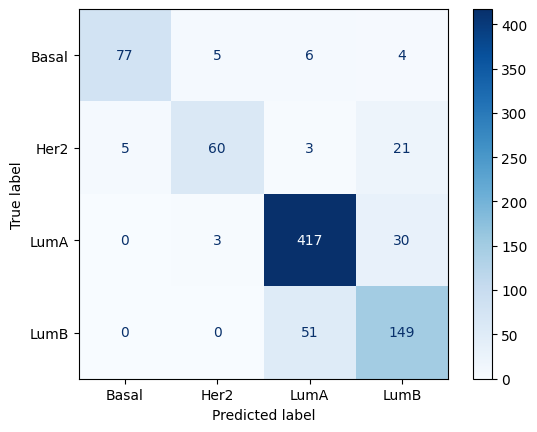

In [18]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

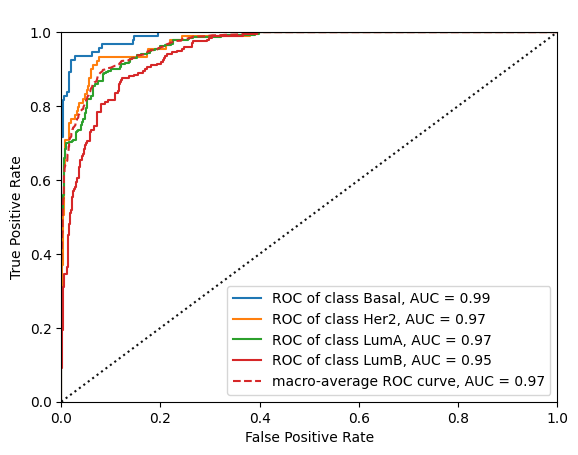

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

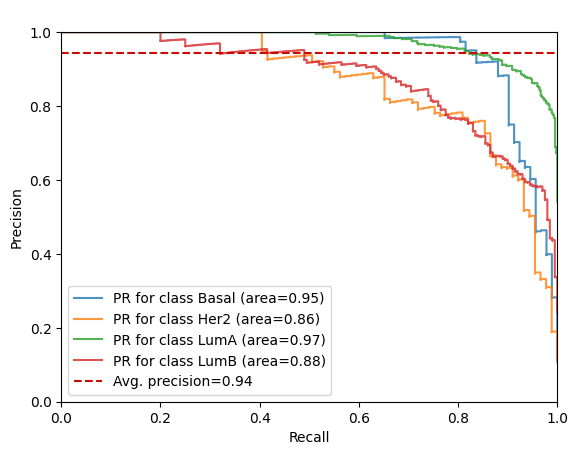

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [20]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], title = " ")
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

In [21]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8459687123947052

In [22]:
# Macro average precision
precision_score(y_test, y_pred, average = "macro")

0.8564958311902764

In [23]:
# Macro average recall
recall_score(y_test, y_pred, average = "macro")

0.7956951229441459

In [24]:
# Macro F1 score
f1_score(y_test, y_pred, average = "macro")

0.8216722048090548

In [25]:
# Macro average AUROC
roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro")

0.9694744098258875